## Feature selection

## Filter: Chi-squared test

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2


df = pd.read_csv('new_train2.csv')
df['label'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
del df['y']

X = df.drop('label', axis=1)
y = df['label']

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical_features = ['age', 'duration', 'campaign']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse=False), categorical_features)
    ]
)


X_processed = preprocessor.fit_transform(X)      

/Users/yi-jiechou/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
num_features_transformed = len(numerical_features)
cat_features_transformed = X_processed.shape[1] - num_features_transformed 

# Define Chi-squared selector for the categorical features 
chi2_selector = SelectKBest(chi2, k=20)  # Adjust 'k' as needed

X_selected = chi2_selector.fit_transform(X_processed[:, -cat_features_transformed:], y)
X_final = np.concatenate((X_processed[:, :num_features_transformed], X_selected), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

In [3]:
models = [
    (LogisticRegression(solver='liblinear', max_iter=1000), "Logistic Regression"),
#     (KNeighborsClassifier(), "KNN"),
#     (GaussianNB(), "Naive Bayes"),
#     (DecisionTreeClassifier(), "Decision Tree"),
    (RandomForestClassifier(), "Random Forest"),
]

Test Accuracy for Logistic Regression: 0.9005
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      8768
           1       0.61      0.34      0.43      1119

    accuracy                           0.90      9887
   macro avg       0.76      0.65      0.69      9887
weighted avg       0.88      0.90      0.89      9887



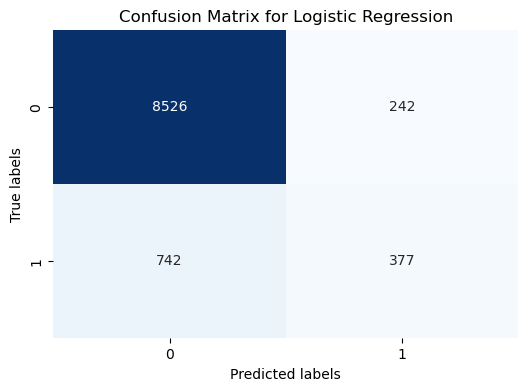

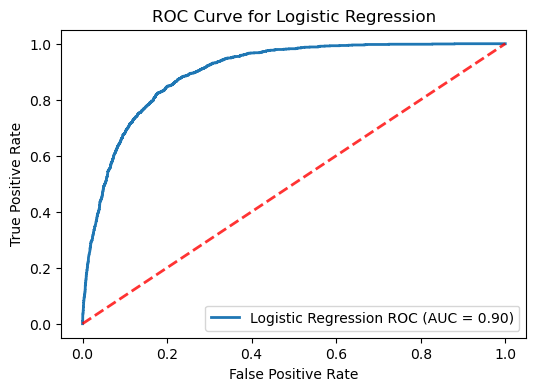

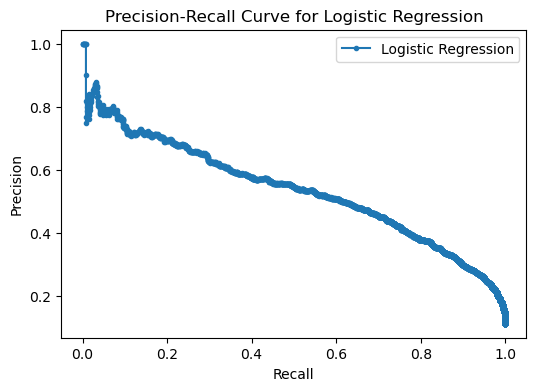

Test Accuracy for Random Forest: 0.8971
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      8768
           1       0.56      0.44      0.49      1119

    accuracy                           0.90      9887
   macro avg       0.74      0.70      0.72      9887
weighted avg       0.89      0.90      0.89      9887



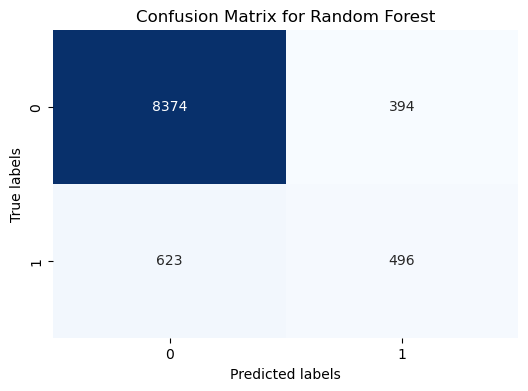

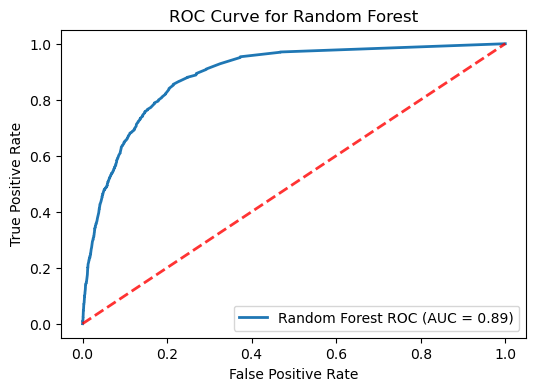

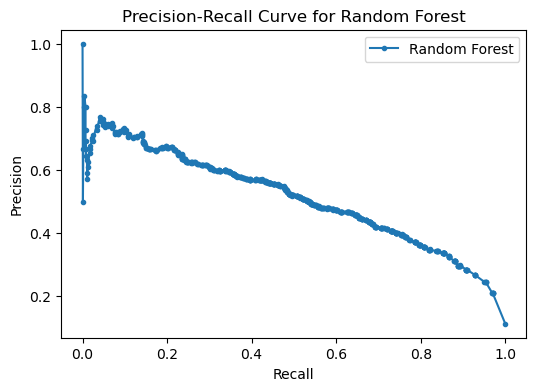

In [4]:
# Train, validate, and test using the selected features
for model, model_name in models:
    model.fit(X_train, y_train)
    
    # Testing
    y_pred = model.predict(X_test)
    print(f"Test Accuracy for {model_name}: {accuracy_score(y_test, y_pred):.4f}")
    
    # Classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # ROC curve
    if hasattr(model, "predict_proba"):
        probas_ = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'{model_name} ROC (AUC = {roc_auc:.2f})', lw=2)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc="lower right")
        plt.show()
    
    # Precision Recall curve
    if hasattr(model, "predict_proba"):
        precision, recall, _ = precision_recall_curve(y_test, probas_)
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, marker='.', label=model_name)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {model_name}')
        plt.legend()
        plt.show()

In [5]:
feature_names_transformed = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=categorical_features)
selected_mask = chi2_selector.get_support()
selected_features = feature_names_transformed[selected_mask]

print("Selected features:", selected_features)

Selected features: ['job_blue-collar' 'job_retired' 'job_services' 'job_student'
 'marital_single' 'education_basic.9y' 'education_university.degree'
 'default_no' 'default_unknown' 'contact_cellular' 'contact_telephone'
 'month_apr' 'month_dec' 'month_mar' 'month_may' 'month_oct' 'month_sep'
 'poutcome_failure' 'poutcome_nonexistent' 'poutcome_success']
